In [1]:
import res.census_mapper
from zipfile import ZipFile
import io
import shapefile
from shapely.geometry import shape
import osr
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
import numpy as np
import folium
import random

In [18]:
blocks = ZipFile('res/tl_2015_13_bg.zip')
filenames = [y for y in sorted(blocks.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [io.BytesIO(blocks.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  

proj4_string = osr.SpatialReference(prj.read().decode('UTF-8')).ExportToProj4()
print(proj4_string)

blockgdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)
print(blockgdf.head())

+proj=longlat +ellps=GRS80 +no_defs 
     ALAND  AWATER BLKGRPCE COUNTYFP FUNCSTAT         GEOID     INTPTLAT  \
0  2213449   79182        2      089        S  130890212022  +33.9151116   
1   412353       0        1      089        S  130890212041  +33.8884823   
2  1124764       0        2      089        S  130890212082  +33.9104582   
3  1000826       0        3      021        S  130210131023  +32.7925035   
4   807552       0        4      021        S  130210131024  +32.7897447   

       INTPTLON  MTFCC       NAMELSAD STATEFP TRACTCE  \
0  -084.3275107  G5030  Block Group 2      13  021202   
1  -084.2911951  G5030  Block Group 1      13  021204   
2  -084.3053062  G5030  Block Group 2      13  021208   
3  -083.6973228  G5030  Block Group 3      13  013102   
4  -083.7020427  G5030  Block Group 4      13  013102   

                                            geometry  
0  POLYGON ((-84.338275 33.918159, -84.337988 33....  
1  POLYGON ((-84.294645 33.891111, -84.294631 33.... 

In [36]:
blocks = {}
i = 0
with open("res/Race.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        blocks[row['Id2']] = [row['Estimate'], row['White'], row['Black'], row['Other']]
with open("res/SexAge.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Id2'] in blocks:
            blocks[row['Id2']] += [row['Male'], row['Female'], row['Young'], row['Mid'], row['Old'], 0]
with open("res/Income.csv", "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Id2'] in blocks:
            blocks[row['Id2']][-1] = row['Median']
            
for block in blocks:
    for i, ent in enumerate(blocks[block]):
        #print(ent)
        blocks[block][i] = int(str(ent).replace("+","").replace(",","").replace("-","0"))
    #for i, ent in enumerate(blocks[block]):
    #    if i > 1 and blocks[block][1] > 0:
    #        blocks[block][i] = 100 * blocks[block][i] / blocks[block][1]
        
#print(blocks)
#for geoid in blockgdf['geoid']

In [39]:
arr = []

for geoid in blockgdf.GEOID:
    #print(geoid)
    if str(geoid) in blocks:
        arr.append(blocks[str(geoid)])
        #print(len(arr[-1]))
    else:
        arr.append([0]*10)
    
#print(len(blockgdf.GEOID))
#print(len(arr))

#print(arr)
arr = np.asarray(arr)

feats = ['POP', 'WHITE', 'BLACK', 'OTHER_RACE', 'MALE', 'FEMALE', 'YOUNG', 'MIDAGE', 'OLD', 'INCOME']

#print(arr)

for i, feat in enumerate(feats):
    blockgdf[feat] = arr[:, i]
    blockgdf[feat+"A"] = arr[:, i]/(blockgdf.ALAND+blockgdf.AWATER)
    if i > 0 and i < 9:
        q = [0]*len(arr[:, i])
        for ind, a in enumerate(q):
            if arr[ind, 1] == 0:
                q[ind] = 0
            else:
                q[ind] = arr[ind, i]/arr[ind,0]
        blockgdf[feat+"P"] = q



In [40]:
atl = ZipFile('res/Atlanta_City_Limits.zip')
filenames = [y for y in sorted(atl.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [io.BytesIO(atl.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)

attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  

proj4_string = osr.SpatialReference(prj.read().decode('UTF-8')).ExportToProj4()
print(proj4_string)

atlgdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)
print(atlgdf.head())

+proj=longlat +ellps=WGS84 +no_defs 
     ACRES                                GLOBALID  ID    LABEL  OBJECTID  \
0  86643.1  {6999F328-8F07-4EE0-BF8C-4DB531A3898C}   0  Atlanta         1   

   OBJECTID_1    SHAPE_Area     SHAPE_Leng  SQ_MILES  \
0           1  5.087264e+08  195314.168371    135.38   

                                            geometry  
0  (POLYGON ((-84.42135081494511 33.6588738469827...  


In [42]:
#dead = blockgdf[blockgdf.geometry.intersects(atlgdf.geometry[0])]
#dead = dead[dead.POP == 0]
#print(dead)

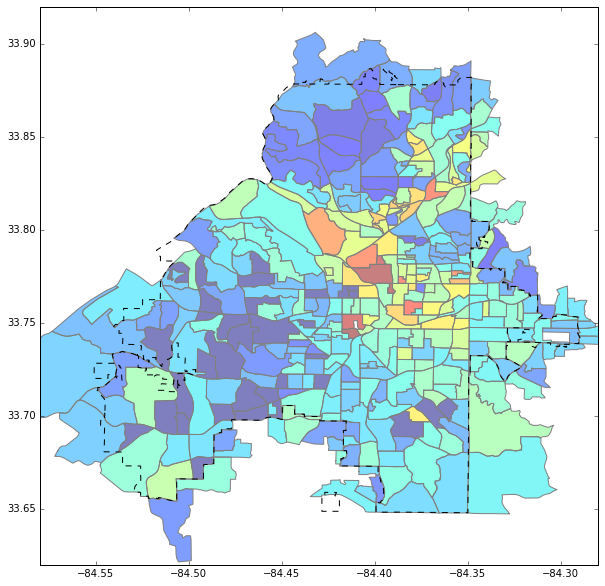

In [43]:
plt.clf()

fig, ax = plt.subplots(figsize=(10,10))

blockgo = blockgdf[blockgdf.geometry.intersects(atlgdf.geometry[0])]
blockgo = blockgo[blockgo.POP > 0]
blockgo = blockgo[blockgo.GEOID != 131210103042]
#blockgdf = blockgdf[blockgdf.GEOID != 131210103042]
#mask2 = 
#print(mask)

blockgo.plot(ax = ax, column='YOUNGP', edgecolor='grey')
#blockgdf[blockgdf.geometry.within(atlgdf.geometry[0])].plot(ax = ax)
atlgdf.plot(ax=ax, facecolor='none', alpha=0.4, ls='--')

plt.xlim((-84.58,-84.28))
plt.ylim((33.62,33.92))

plt.show()

In [44]:
m = folium.Map(location=[33.5, -84.4], zoom_start=10, 
               tiles='Stamen Toner')

#threshold_scale = np.linspace(blockgdf['INCOME'].min(),
#                              blockgdf['INCOME'].max(), 6, dtype=int).tolist()
geo_str = (blockgo).to_json()

#linear = folium.colormap.LinearColormap(['green', 'yellow', 'red'])
m.choropleth(geo_str=geo_str,
             data=blockgo,columns=['GEOID','YOUNGP'],
             key_on='feature.properties.GEOID',
             fill_color="PuBuGn", 
             fill_opacity=0.8, line_opacity=0.8,
             legend_name='area')

atlgeo = atlgdf.to_json()
m.choropleth(geo_str=atlgeo, fill_color='None', line_color='black', line_weight=2)

m

In [24]:
blockgdf.keys()

Index(['ALAND', 'AWATER', 'BLKGRPCE', 'COUNTYFP', 'FUNCSTAT', 'GEOID',
       'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAMELSAD', 'STATEFP', 'TRACTCE',
       'geometry', 'INCOME', 'INCOMEA', 'POP', 'POPA', 'WHITE', 'WHITEA',
       'WHITEP', 'BLACK', 'BLACKA', 'BLACKP', 'OTHER_RACE', 'OTHER_RACEA',
       'OTHER_RACEP', 'MALE', 'MALEA', 'MALEP', 'FEMALE', 'FEMALEA', 'FEMALEP',
       'YOUNG', 'YOUNGA', 'YOUNGP', 'MIDAGE', 'MIDAGEA', 'MIDAGEP', 'OLD',
       'OLDA', 'OLDP', 'rand'],
      dtype='object')